In [68]:

"""PRK_for_optimization.ipynb

Original file is located at
    https://colab.research.google.com/drive/13UUnSTdrjEjeRSajllr_KsPZxv4IJOWJ
"""

from jax.config import config
config.update("jax_enable_x64", True)  #double precision


import numpy as np
from jax import jit
import jax

import jax.numpy as jnp
import numpy as np
from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd
from jax import grad, jit, vmap, pmap
from jax._src.lax.utils import (
    _argnum_weak_type,
    _input_dtype,
    standard_primitive,
)
from jax._src.lax import lax

def One_Dim_Matrix(A):
    dim_x, dim_y = A.shape
    A = A.reshape(1, (dim_x * dim_y))
    return A

def Add_B_tomatrix_A(A, b):
    A = jnp.append(A,b)
    return A

def actual_A_1D(A):
    b1 = A[16:20]
    A_new = A[0:16]
    return A_new, b1

def actual_A1_A2(A): # from the returned gradient array of 20 elements, we find the elements of array A and array B
                    # first 16 elemets belong to lower triangular elements of array A and 4 belongs to B
    A1 = A[0:20]
    A2 = A[20:40]
    return A1, A2

def One_D_to_TwoD(A):
    A = A.reshape(4, 4)
    return A

#Energy Preserving Method :
def f(y, z, alpha_values):
    return z

def g(y, z, alpha_values):
    alpha_values = alpha_values.transpose()
    return jnp.add(jnp.add((-1 * alpha_values[0]) , (-2 * alpha_values[1] * y) ) , jnp.add((-3 * alpha_values[2]* (y**2)) , (-4 * alpha_values[3] * (y**3) )) )

def Energy_Function(y, z, alpha_values):
    return ((jnp.square(y))/2 + jnp.add(jnp.add(( alpha_values[0]* (z)) , (alpha_values[1] * (z**2)) ) , jnp.add((alpha_values[2]* (z**3)) , (alpha_values[3] * (z**4) )) )) 

# def f(y, z, alpha_values):
#     return z

# def g(y, z, alpha_values):
#     return -y

# def Energy_Function(y, z, alpha_values):
#     return (jnp.square(y) + jnp.square(z))/2


def PRK_step(y0 , z0, h, A1, A2, B1, B2, alpha_values):
    s = A1.shape[0]
    dim = jnp.size(y0)
    tol = 10**(-10)
    K_old = jnp.zeros((s,dim))
    L_old = jnp.zeros((s,dim))
    K_new = f((y0+ h*A1 @ K_old), (z0+ h*A2 @ L_old), alpha_values)
    L_new = g((y0+ h*A1 @ K_old), (z0+ h*A2 @ L_old), alpha_values)

    init_state = 0, K_new, L_new, K_old, L_old, alpha_values

    def body_while_loop(state):
        _, K_new, L_new, K_old, L_old, alpha_values = state
        K_old = K_new
        L_old = L_new
        K_new = f(y0+ h * A1 @ K_old, z0 + h * A2 @ L_old, alpha_values)
        L_new = g(y0+ h * A1 @ K_old, z0 + h * A2 @ L_old, alpha_values)
        return _, K_new, L_new, K_old, L_old, alpha_values

    def condition_while_loop(state):
        _, K_new, L_new, K_old, L_old, alpha_values = state
        norms = jnp.sum(jnp.array([jnp.linalg.norm(K_new - K_old) + jnp.linalg.norm(L_new - L_old)]))
        return norms > tol

    _, K_new, L_new, K_old, L_old, alpha_values = jax.lax.while_loop(condition_while_loop, body_while_loop, init_state)
    yn = y0 + h * jnp.sum(jnp.multiply(B1, K_new))
    zn = z0 + h * jnp.sum(jnp.multiply(B2, L_new))

    return yn, zn

def find_error(A1D, H_sequence, stepss):
    #converting A1D back to the original matrix form

    time_factor = 1
    a1, a2 = actual_A1_A2(A1D) #, H_sequence
    a1,B1 = actual_A_1D(a1)
    A1 = One_D_to_TwoD(a1)
    a2,B2 = actual_A_1D(a2)
    A2 = One_D_to_TwoD(a2)

    B1 = jnp.reshape(B1, (4, 1))
    B2 = jnp.reshape(B2, (4, 1))
    # print("==== shape of B1, and B2 : ", B1.shape, B2.shape)

    alpha_values = jnp.reshape(jnp.array(H_sequence[:4]), (1, 4))

    y0 = jnp.reshape(jnp.array(H_sequence[4]), (1, 1)) # jnp.zeros((1,1)) #
    z0 = jnp.reshape(jnp.array(H_sequence[5]), (1, 1)) # jnp.ones((1,1)) #

    istep = 10
    i = 0
    NN = jnp.array([int(1/stepss)]) ## used for steps

    yn_list = jnp.zeros((time_factor * NN[i] , 1))
    zn_list = jnp.zeros((time_factor * NN[i] , 1))
    iyn_list = jnp.zeros((time_factor * istep * NN[i] , 1))
    izn_list = jnp.zeros((time_factor * istep * NN[i] , 1))

    yn = zn = iyn = izn = []
    
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@", stepss, NN[i], int(NN[i]))
    h = time_factor/NN[i] #step size
    y = iy = y0
    z = iz = z0

    def fori_loop_1(i, state):
        yn_list, zn_list, y, z, A1, A2, B1, B2, alpha_values = state
        y, z = PRK_step(y, z, h, A1, A2, B1, B2, alpha_values)
        yn_list = yn_list.at[i].set(y.ravel())
        zn_list = zn_list.at[i].set(z.ravel())
        state = yn_list, zn_list, y, z, A1, A2, B1, B2, alpha_values
        return state
    init_state_yz = yn_list, zn_list, y, z, A1, A2, B1, B2, alpha_values
    yn_list, zn_list, what_y, what_z, _, _, _, _, _ = jax.lax.fori_loop(0, time_factor * NN[i], fori_loop_1, init_state_yz)

    H = Energy_Function(yn_list, zn_list, alpha_values) # H should be of type list
    energy_error = jnp.sum(jnp.square(H - H[0])) / len(H)

    def fori_loop_2(j, state):
        iyn_list, izn_list, iy, iz, A1, A2, B1, B2, alpha_values = state
        iy, iz = PRK_step(iy, iz, h/istep, A1, A2, B1, B2, alpha_values)
        iyn_list = iyn_list.at[j].set(iy.ravel())
        izn_list = izn_list.at[j].set(iz.ravel())
        state = iyn_list, izn_list, iy, iz, A1, A2, B1, B2, alpha_values
        return state
    init_state_iyz = iyn_list, izn_list, iy, iz, A1, A2, B1, B2, alpha_values
    iyn_list, izn_list, _, _, _, _, _, _, _ = jax.lax.fori_loop(0, time_factor * istep * NN[i], fori_loop_2, init_state_iyz) # time istep
    
    j1_iyn_list = iyn_list[9:time_factor*istep*NN[i]:istep]
    j2_izn_list = izn_list[9:time_factor*istep*NN[i]:istep]

    print(len(iyn_list), "++++++++++++++++++++++++++++++++++++++++")
    print(len(izn_list), "++++++++++++++++++++++++++++++++++++++++")
    print(len(j1_iyn_list), "-------------------------------------")
    print(len(j2_izn_list), "-------------------------------------")
    print(len(yn_list), "###########################")
    print(len(zn_list), "###########################")
    err1 = j1_iyn_list.ravel() - yn_list.ravel() ## y error
    err2 = j2_izn_list.ravel() - zn_list.ravel() ## z error

    final_error = (jnp.sum(jnp.abs(err1)) + jnp.sum(jnp.abs(err2))) / (2*NN[i])

    return jnp.sum(final_error) + energy_error




SyntaxError: invalid syntax (3480682917.py, line 52)

Below code can be removed when making a calling function :

In [72]:
from skopt.space import Space
from skopt.sampler import Halton
spacedim = [(-0.1, 0.5),(-0.1, 0.5),(-0.1, 0.5),(-0.1, 0.5),(-0.1, 0.5),(-0.1, 0.5)]

space = Space(spacedim)

halton = Halton()
n = 10

# # RK4 fourth-order
A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [1/2, 0., 0., 0.],
     [0., 1/2, 0., 0.],
     [0., 0., 1.0, 0.]])
B1 = B2 = jnp.array([1/6, 1/3, 1/3, 1/6])


# # Lobatto 3A and B fourth order
# A1 = jnp.array([
#      [0., 0., 0., 0.],
#      [5/24, 1/3, -1/24, 0.],
#      [1/6, 2/3, 1/6, 0.],
#      [0., 0., 0., 0.]])
# B1 = jnp.array([1/6, 2/3, 1/6, 0.])

# # Lobatto IIIB fourth-order
# A2 = jnp.array([
#      [1/6, -1/6, 0., 0.],
#      [1/6, 1/3, 0., 0.],
#      [1/6, 5/6, 0., 0.],
#      [0., 0., 0., 0.]])
# B2 = jnp.array([1/6, 2/3, 1/6, 0.])


# A1 = jnp.array([[ 5.53973005e-03,  3.46913523e-03,  3.18286485e-03,  1.22930961e-03],
#  [ 5.04332272e-01,  1.96742666e-03,  1.64670634e-03, -5.80220214e-04],
#  [ 2.68698796e-02,  5.17115926e-01,  1.57552065e-02,  6.54755869e-03],
#  [ 6.86121219e-03,  4.43143438e-03,  1.00409120e+00,  1.79680051e-03]] )
# A1 = jnp.array([[ 0.00229433,  0.00183229,  0.00176991,  0.00135274],
#  [ 0.49509345, -0.00548142, -0.00553493, -0.006034  ],
#  [ 0.01739194,  0.51515324,  0.01483539,  0.01279466],
#  [ 0.00554208,  0.00499206,  1.00491006,  0.00440536]])

# B1 = jnp.array([0.13177591, 0.14890188, 0.64823509, 0.16240862])
# B2 = jnp.array([0.13613692, 0.15761855, 0.65101443, 0.16207834])

halton_sequence = halton.generate(space, n)
halton_sequence = np.array(halton_sequence)


# print(halton_sequence)

A1D = One_Dim_Matrix(A1)
A1D = Add_B_tomatrix_A(A1D, B1)

A2D = One_Dim_Matrix(A2)
A2D = Add_B_tomatrix_A(A2D, B2)

A1D = Add_B_tomatrix_A(A1D, A2D)
# A1D = Add_B_tomatrix_A(A1D, halton_sequence[1])

sss = 1

step_size_list_convergence = []
error_list_convergence = []

for i in range(6):
  e1 = find_error(A1D, halton_sequence[1], 1/sss)
  step_size_list_convergence.append(1/sss)
  error_list_convergence.append(e1)

  sss *= 10
  print("Hi")
print(e1)
# print(e1[0])
# print(e1[4][9])
# print("here :", e1[4], e1[5], e1[6])

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 1.0 1 1
10 ++++++++++++++++++++++++++++++++++++++++
10 ++++++++++++++++++++++++++++++++++++++++
1 -------------------------------------
1 -------------------------------------
1 ###########################
1 ###########################
Hi
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 0.1 10 10
100 ++++++++++++++++++++++++++++++++++++++++
100 ++++++++++++++++++++++++++++++++++++++++
10 -------------------------------------
10 -------------------------------------
10 ###########################
10 ###########################
Hi
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 0.01 100 100
1000 ++++++++++++++++++++++++++++++++++++++++
1000 ++++++++++++++++++++++++++++++++++++++++
100 -------------------------------------
100 -------------------------------------
100 ###########################
100 ###########################
Hi
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 0.001 1000 1000
10000 ++++++++++++++++++++++++++++++++++++++++
10000 ++++++++++++++++++++++++++++++++++++++++
1000

In [73]:
print(sss)
print(error_list_convergence)
print(step_size_list_convergence)

1000000
[Array(0.00040973, dtype=float64), Array(1.93496028e-08, dtype=float64), Array(1.75217168e-12, dtype=float64), Array(1.29197942e-16, dtype=float64), Array(4.12424288e-16, dtype=float64), Array(1.2935022e-15, dtype=float64)]
[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]


# Graphs

Text(0, 0.5, 'Log Error')

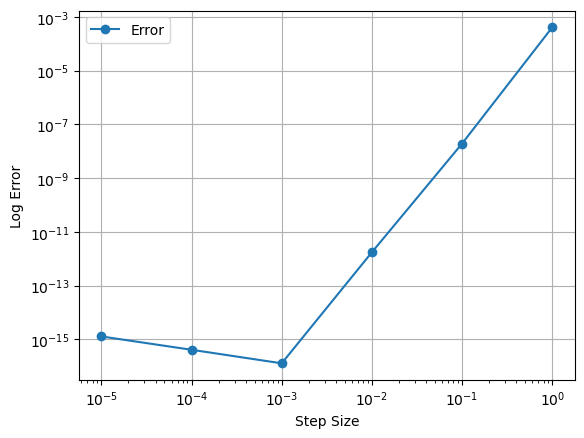

In [74]:
import matplotlib.pyplot as plt

# Convergence

# o_error_list_convergence = jnp.array(o_error_list_convergence)
# o_error_list_convergence = jnp.log(o_error_list_convergence) / jnp.log(10)
# c_error_list_convergence = jnp.array(c_error_list_convergence)
# c_error_list_convergence = jnp.log(c_error_list_convergence)/jnp.log(10)
# plt.plot(step_size_list_convergence, o_error_list_convergence, label = "Error",marker='o')
# plt.plot(step_size_list_convergence, c_error_list_convergence, label = "Error",marker='s')


plt.loglog(step_size_list_convergence, error_list_convergence, label = "Error",marker='o')
# plt.loglog(step_size_list_convergence, c_error_list_convergence, label = "Error",marker='s')

plt.legend()
plt.grid()
plt.xlabel('Step Size')
plt.ylabel('Log Error')